# Analyse du data

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/23 15:10:18 WARN Utils: Your hostname, DESKTOP-3IKPR1U, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/23 15:10:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/23 15:10:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# loading data
df_bronze = spark.read.parquet("/mnt/c/Users/hp/Desktop/Urban-ETA-ML-Platform/data/dataset.parquet")
df_bronze.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [ ]:
df_bronze.coalesce(1)\
    .write.mode("overwrite")\
    .parquet("/mnt/c/Users/hp/Desktop/Urban-ETA-ML-Platform/data/bronze/bronze_dataset")


In [4]:
#  data types
df_bronze.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [5]:

df_bronze.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'cbd_congestion_fee']

In [6]:
df_bronze.describe().show()

26/01/23 15:11:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [7]:
from pyspark.sql.functions import col, sum as spark_sum, when
df_bronze.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
      for c in df_bronze.columns
      ]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|         540149|            0|    540149|            540149|           0|    

In [12]:
#drop rows where target is null 
df_silver = df_bronze.na.drop(subset=["RatecodeID", "store_and_fwd_flag", "congestion_surcharge", "Airport_fee"])

In [13]:
# from pyspark.sql.functions import col, sum as spark_sum

df_silver.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in ["passenger_count", "RatecodeID", "store_and_fwd_flag", "congestion_surcharge", "Airport_fee"]
]).show()


+---------------+----------+------------------+--------------------+-----------+
|passenger_count|RatecodeID|store_and_fwd_flag|congestion_surcharge|Airport_fee|
+---------------+----------+------------------+--------------------+-----------+
|              0|         0|                 0|                   0|          0|
+---------------+----------+------------------+--------------------+-----------+



In [14]:
print("Nombres des lingne:", df_silver.count())

Nombres des lingne: 2935077


In [15]:
uniques_lignes = df_silver.dropDuplicates().count()
print(f"Nombre de lignes uniques :{uniques_lignes}")

Nombre de lignes uniques :2935077


In [16]:
#  Calcul de la Cible
from pyspark.sql import functions as f

df_silver = df_silver.withColumn("duration_minutes", 
    (f.unix_timestamp("tpep_dropoff_datetime") - f.unix_timestamp("tpep_pickup_datetime")) / 60
)
df_silver.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|  duration_minutes|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|    

In [18]:
# Filtrer les durees aberrantes
df_silver = df_silver.filter(f.col("duration_minutes") > 0)
df_silver = df_silver.filter(f.col("duration_minutes") < 180)

# Filtrer les distances aberrantes
df_silver = df_silver.filter(f.col("trip_distance") > 0)
df_silver = df_silver.filter(f.col("trip_distance") < 200)

# Filtrer le nombre de passagers
df_silver = df_silver.filter(f.col("passenger_count") > 0)

# Filtrer les valeurs negatifs
df_silver = df_silver.filter(f.col("fare_amount") >= 0)
df_silver = df_silver.filter(f.col("total_amount") >= 0)

In [19]:
# gestion des outliers de la cible par log1p
df_silver = df_silver.withColumn(
    "trip_duration",
    f.log1p(f.col("duration_minutes"))
)

In [20]:
# Extraire l'heure
df_silver = df_silver.withColumn("pickup_hour", f.hour("tpep_pickup_datetime"))

# Extraire le jour de la semaine
df_silver = df_silver.withColumn("day_of_week", f.dayofweek("tpep_pickup_datetime"))

# Extraire le mois
df_silver = df_silver.withColumn("month", f.month("tpep_pickup_datetime"))



df_silver.select("pickup_hour", "day_of_week", "month").show(10)



+-----------+-----------+-----+
|pickup_hour|day_of_week|month|
+-----------+-----------+-----+
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
|          0|          4|    1|
+-----------+-----------+-----+
only showing top 10 rows


# Visualisation

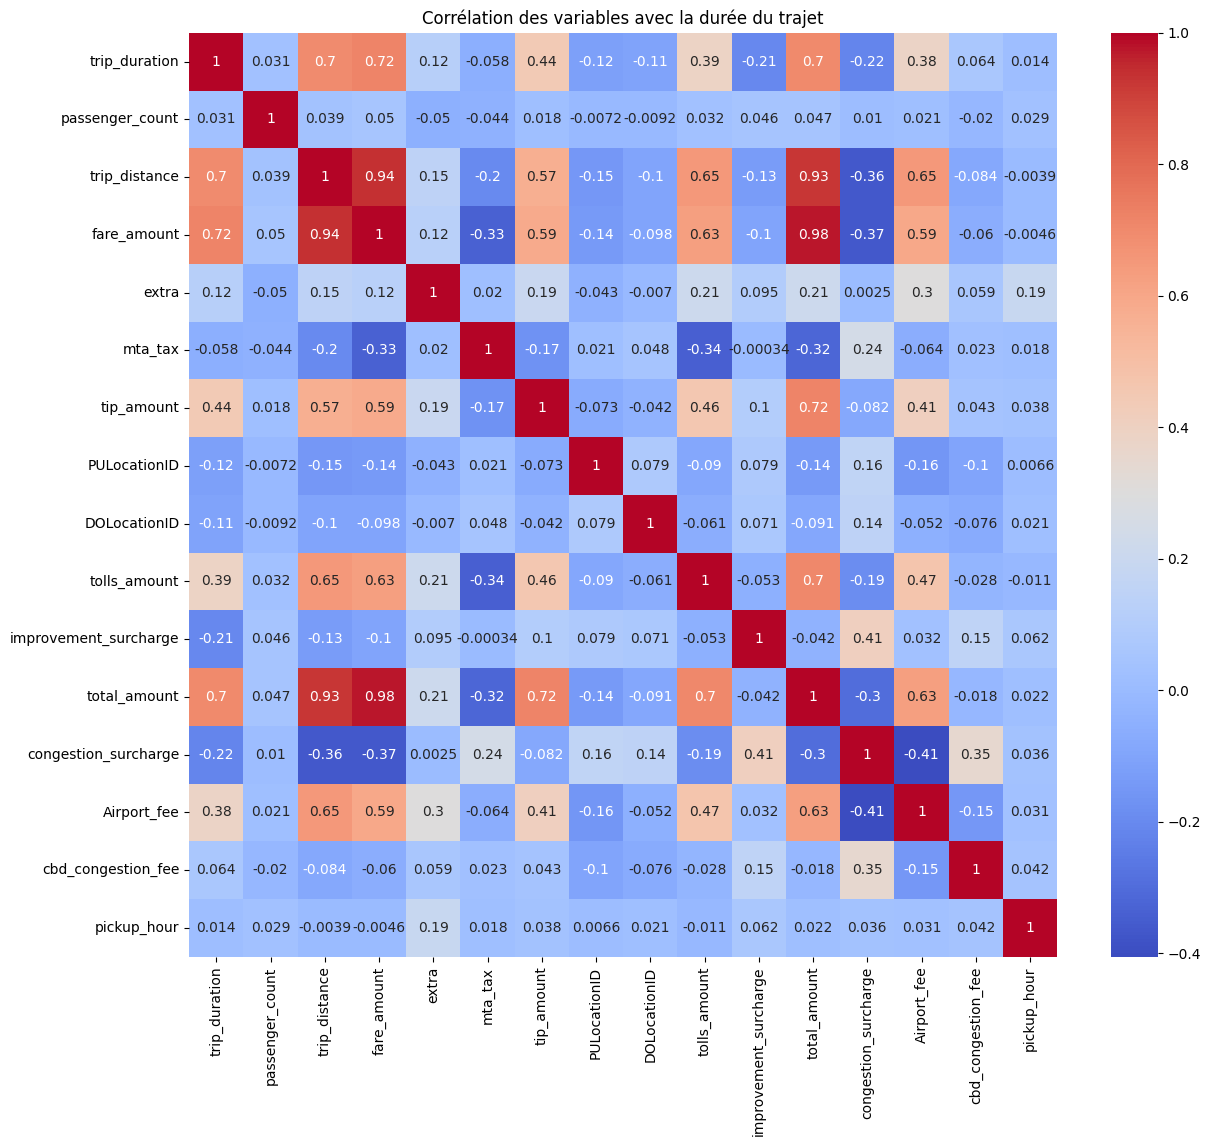

In [21]:
# matrice de correlation

import seaborn as sns
import matplotlib.pyplot as plt

col_num = [
    "trip_duration",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "PULocationID",
    "DOLocationID",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee"
]
num_cols = col_num + ["pickup_hour"]
sampled_df = df_silver.select(num_cols).sample(False, 0.1).toPandas()


plt.figure(figsize=(14,12))
corr = sampled_df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Corrélation des variables avec la durée du trajet")
plt.show()


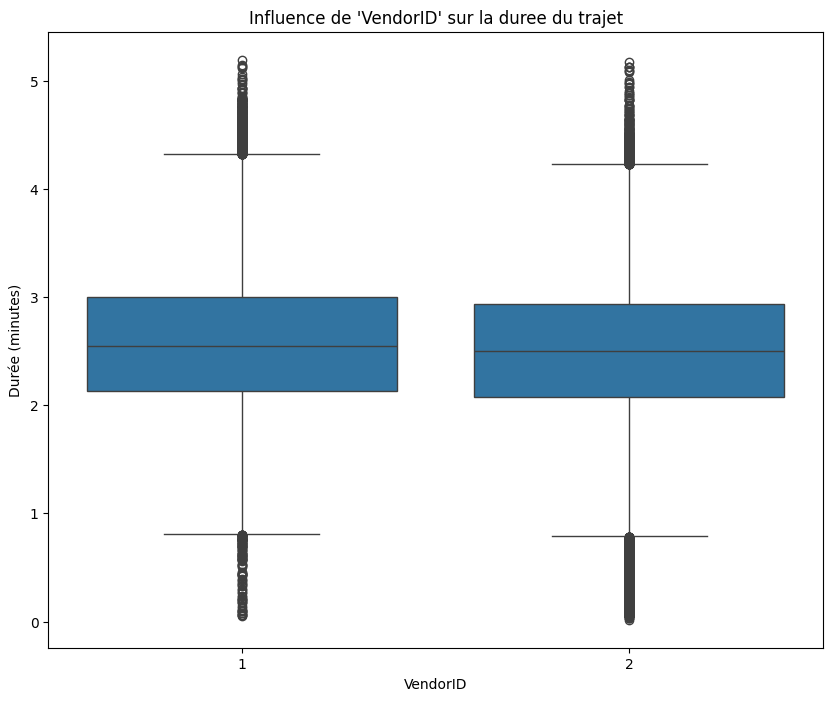

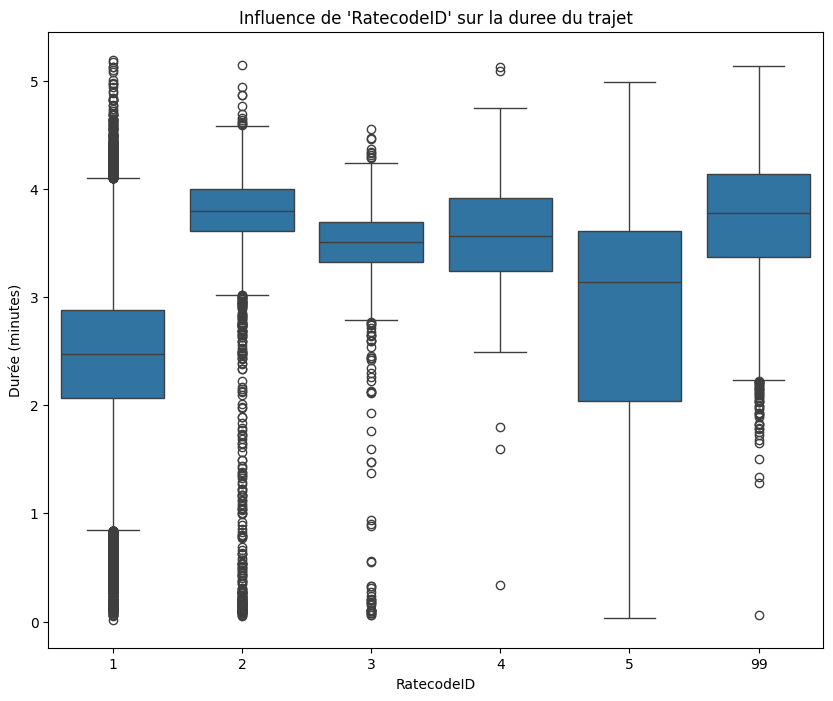

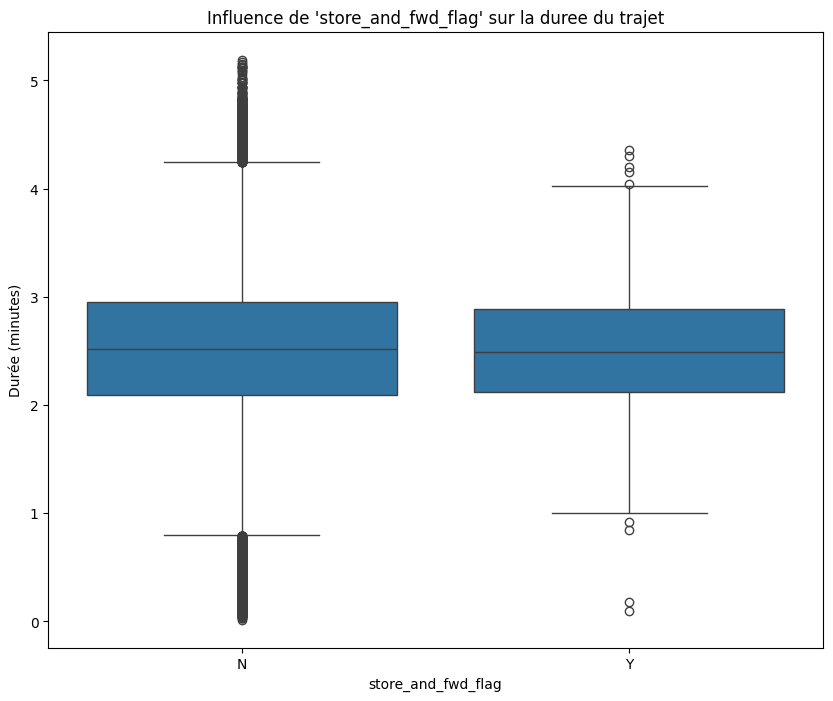

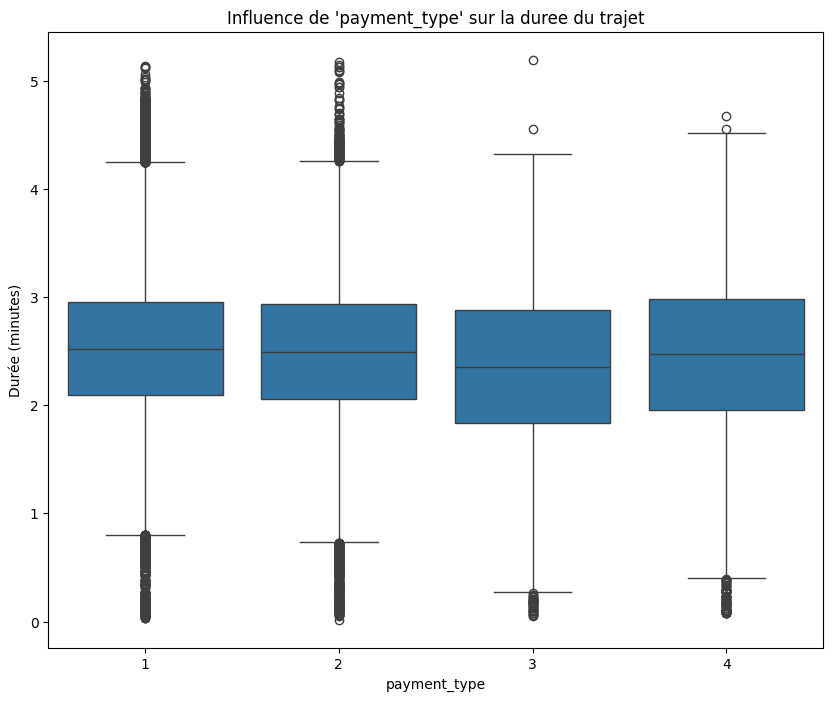

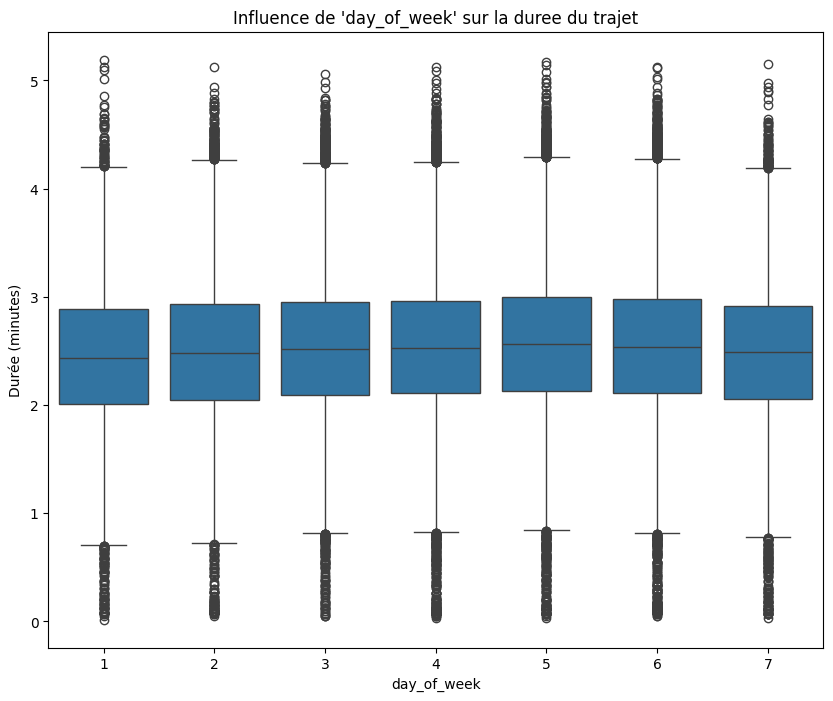

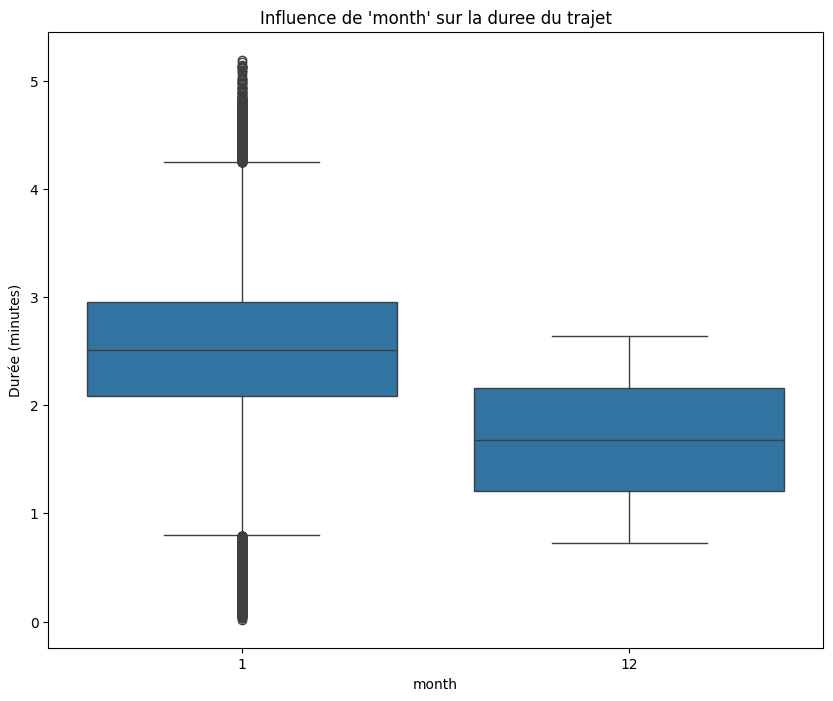

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = [
    "VendorID",
    "RatecodeID",
    "store_and_fwd_flag",
    "payment_type",
    "day_of_week",
    "month"
]

sampled_df = df_silver.select(cat_cols + ["trip_duration"]).sample(False, 0.1) .toPandas()

for var in cat_cols:
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=sampled_df, x=var, y="trip_duration")
    plt.title(f"Influence de '{var}' sur la duree du trajet")
    plt.xlabel(var)
    plt.ylabel("Durée (minutes)")
    plt.show()

In [23]:
# Filtrer le nombre de passagers
df_silver = df_silver.filter(f.col("RatecodeID") <= 5)

In [24]:
df_bronze = df_silver.drop("VendorID", "tpep_pickup_datetime", "store_and_fwd_flag" , "tpep_dropoff_datetime", "passenger_count", "extra", "mta_tax","PULocationID",
               "DOLocationID", "improvement_surcharge", "congestion_surcharge", "cbd_congestion_fee", "day_of_week", "duration_minutes")

print(df_bronze.columns)
num_cols= [ 'trip_distance',
            'fare_amount',
            'total_amount',
            'tip_amount',
            'Airport_fee',
            'tolls_amount'
            
          ]

['trip_distance', 'RatecodeID', 'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'Airport_fee', 'trip_duration', 'pickup_hour', 'month']


In [ ]:
df_bronze.coalesce(1)\
    .write.mode("overwrite")\
    .parquet("/mnt/c/Users/hp/Desktop/Urban-ETA-ML-Platform/data/silver/silver_dataset")


# Modilisation

In [26]:
from pipeline import split_data, model_pipeline, metric_model

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression


In [27]:
# pipeline linear regression
train_df, test_df = split_data(df_silver, target="trip_duration")

pipeline_LR = model_pipeline(num_cols, LinearRegression())


In [28]:
#  entrainement du model de linear regresion
model_LR = pipeline_LR.fit(train_df)


26/01/23 15:29:34 WARN Instrumentation: [84db9308] regParam is zero, which might cause numerical instability and overfitting.
26/01/23 15:29:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/23 15:29:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [29]:
#  metrics de linear regresion
y_pred_LR = model_LR.transform(test_df)

mae, rmse, r2 = metric_model(y_pred_LR)

print("mae", mae)
print("rmse", rmse)
print("r2_score", r2)

mae 0.3440971888195438
rmse 0.44426449593531653
r2_score 0.514102923929614


In [30]:
# pipeline random forest
train_df, test_df = split_data(df_bronze, target="trip_duration")

pipeline_RF = model_pipeline(num_cols, RandomForestRegressor(numTrees=100))

In [31]:
#  entrainement du model de random forest
model_RF = pipeline_RF.fit(train_df)


26/01/23 15:30:34 WARN MemoryStore: Not enough space to cache rdd_191_1 in memory! (computed 13.6 MiB so far)
26/01/23 15:30:34 WARN BlockManager: Persisting block rdd_191_1 to disk instead.
26/01/23 15:30:34 WARN MemoryStore: Not enough space to cache rdd_191_8 in memory! (computed 30.6 MiB so far)
26/01/23 15:30:34 WARN BlockManager: Persisting block rdd_191_8 to disk instead.
26/01/23 15:30:35 WARN MemoryStore: Not enough space to cache rdd_191_5 in memory! (computed 72.5 MiB so far)
26/01/23 15:30:35 WARN BlockManager: Persisting block rdd_191_5 to disk instead.
26/01/23 15:30:45 WARN MemoryStore: Not enough space to cache rdd_191_8 in memory! (computed 163.1 MiB so far)
26/01/23 15:30:47 WARN MemoryStore: Not enough space to cache rdd_191_1 in memory! (computed 163.1 MiB so far)
26/01/23 15:30:48 WARN MemoryStore: Not enough space to cache rdd_191_5 in memory! (computed 244.7 MiB so far)
26/01/23 15:30:54 WARN MemoryStore: Not enough space to cache rdd_191_5 in memory! (computed 1

In [32]:
#  metrics de random forest
y_pred_RF = model_RF.transform(test_df)

mae, rmse, r2 = metric_model(y_pred_RF)

print("mae", mae)
print("rmse", rmse)
print("r2_score", r2)

mae 0.13357265143450453
rmse 0.19081664907765244
r2_score 0.9099733745744316


In [33]:
# sauvgarde du model 

model_RF.write().overwrite().save("spark_model")
